## Using real-data  

For a "real" data test case, we'll test the different aligners/search software on the virus sequences from IMG/VR4.  
In IMG/VR4  [DOI: 10.1093/nar/gkac1037](https://doi.org/10.1093/nar/gkac1037), the host assignment [workflow](https://github.com/jgi-microbiome-data-science/crispr-host-prediction) identifies spacer-protospacer pairs via `blastn -w 8 --dust no ...  --max_target_seqs 1000` which is roughly equivalent to using `blastn -task short` parameter, followed by filtering the results and using the `assign_host.py` script which utilizes the spacers' lineage information.  
Note, we do not compare any filtereing done after the pairing was done, or the host assignment itself - for that reason, we also do not benchmark dedicated host assignment tools like spacerphaser, wish or iphop (even though they may be useful or utilize spacer-protospacer pairs).  

In our benchmark, we'll use a more updated and curated version of the spacer set compared to the one used in IMG/VR4 - we'll use the CRISPR sapcer set from iphop [https://bitbucket.org/srouxjgi/iphop/src/main/#markdown-header-host-databases-and-versions](https://bitbucket.org/srouxjgi/iphop/src/main/#markdown-header-host-databases-and-versions). Specifically, we'll use the June 2025 upload.



## Fetch IMG/VR4
The full IMG/VR4 data can be downloaded from the [JGI portal](https://genome.jgi.doe.gov/portal/pages/dynamicOrganismDownload.jsf?organism=IMG_VR). This requires logining in and selecting the files we want:  
- IMGVR_all_nucleotides-high_confidence.fna
- IMGVR_all_Sequence_information-high_confidence.tsv

For convenience, we'll download the ffasta file from an unstable FTP hosting of them on nersc:
- [IMGVR4_SEQUENCES.fna.zst](https://portal.nersc.gov/genomad/__data__/IMGVR_DATA/IMGVR4_SEQUENCES.fna.zst)


In [ ]:
%%bash
mkdir imgvr4_data
cd imgvr4_data
mkdir spacers contigs

cd contigs
# download the contigs (this may take a while)
wget https://portal.nersc.gov/genomad/__data__/IMGVR_DATA/IMGVR4_SEQUENCES.fna.zst --quiet -O IMGVR4_SEQUENCES.fna.zst
# decompress the file
zstd -d IMGVR4_SEQUENCES.fna.zst
# get the name, length and GC% of the contigs (this may also take a while)
seqkit fx2tab -nl --gc IMGVR4_SEQUENCES.fna  > IMGVR4_SEQUENCES_name_length.tab

Note, we'll use the IMG_VR_2022-09-20_7.1 version of IMG/VR (v4.1, with bugfix in UViG table and protein fasta), and specifically the high-confidence genomes only ( `IMGVR_all_nucleotides-high_confidence.fna`).  
To get the info table, you'll need to login to the JGI portal and download the `IMGVR_all_Sequence_information-high_confidence.tsv` file. The data is free and unrestricted, but still requires registerition or confirming the data use agreement. 


## fetch the spacer set
We are only interested in one (or two) files from the iphop database:
- `All_CRISPR_spacers_nr_clean.fna`
- `Host_Genomes.tsv`



In [ ]:
%%bash
cd imgvr4_data/spacers
wget https://portal.nersc.gov/cfs/m342/iphop/db/extra/All_CRISPR_spacers_nr_clean.fna
wget https://portal.nersc.gov/cfs/m342/iphop/db/extra/Host_Genomes.tsv
# create a table with the name and length of the spacers
seqkit fx2tab -nl All_CRISPR_spacers_nr_clean.fna  > All_CRISPR_spacers_nr_clean_name_length.tab

Next some data wrangling to get the contig info and the spacer info in the same format.

In [ ]:
import os
os.chdir('/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/imgvr4_data/')
import polars as pl
pl.Config(tbl_rows=50)

from bench import *
from bench.utils.functions import *

contigs_file = 'contigs/IMGVR4_SEQUENCES.fna'
spacers_file = 'spacers/All_CRISPR_spacers_nr_clean.fna'

contig_stats = pl.read_csv('contigs/IMGVR4_SEQUENCES_name_length.tab', separator='\t',has_header=False,new_columns=['seqid','length',"GC"])
contig_info = pl.read_csv('contigs/IMGVR_all_Sequence_information-high_confidence.tsv', separator='\t',infer_schema_length=10000, null_values=['N/A'])
contig_info= contig_info.rename({"Coordinates ('whole' if the UViG is the entire contig)":"coordinates"})
contig_info= contig_info.with_columns(
    pl.when(pl.col('coordinates').eq('whole')).then(None).otherwise(pl.col('coordinates')).alias('coordinates')
)
contig_info = contig_info.with_columns(
    pl.concat_str([pl.col('UVIG'),pl.col('Taxon_oid'),pl.col('Scaffold_oid'),pl.col('coordinates')],ignore_nulls=True,separator='|').alias('seqid')
)
print(f"contig_stats.schema: {contig_stats.schema}")
print(f"contig_stats.shape: {contig_stats.shape}")

print(f"contig_info.schema: {contig_info.schema}")
print(f"contig_info.shape: {contig_info.shape}")
contig_stats = contig_stats.join(contig_info, on='seqid', how='inner')

contig_stats = contig_stats.filter(pl.col("length") == pl.col("Length"))
contig_stats = contig_stats.filter(pl.col("Topology") != "GVMAG")

contig_stats = contig_stats.select(["seqid","Taxonomic classification","length","GC","Topology","MIUViG quality","UVIG"])
contig_stats = contig_stats.rename(str.lower)
contig_stats = contig_stats.rename(lambda x: x.lower().replace(" ","_"))

contig_stats = contig_stats.filter(~pl.col("taxonomic_classification").str.contains(";;;;;"))
contig_stats = contig_stats.with_columns(
    pl.when(pl.col("miuvig_quality").str.contains("High-quality|Reference")).then(True).otherwise(False).alias("hq")
)
contig_stats = contig_stats.with_columns([
    pl.col("taxonomic_classification")
    .str.extract(r"r__([^;]*)", 1).alias("realm"),
    pl.col("taxonomic_classification")
    .str.extract(r"k__([^;]*)", 1).alias("kingdom"),
    pl.col("taxonomic_classification")
    .str.extract(r"p__([^;]*)", 1).alias("phylum"),
    pl.col("taxonomic_classification")
    .str.extract(r"c__([^;]*)", 1).alias("class"),
    pl.col("taxonomic_classification")
    .str.extract(r"o__([^;]*)", 1).alias("order"),
    pl.col("taxonomic_classification")
    .str.extract(r"f__([^;]*)", 1).alias("family"),
    pl.col("taxonomic_classification")
    .str.extract(r"g__([^;]*)", 1).alias("genus"),
    pl.col("taxonomic_classification")
    .str.extract(r"s__([^;]*)", 1).alias("species"),
])
contig_stats = contig_stats.drop(["taxonomic_classification","miuvig_quality"])
for i in contig_stats.columns:
    print(f"{i}: {contig_stats[i].value_counts(sort=True)}")
# tmp.head(3)
print(f"new schema: {contig_stats.schema}")
contig_stats.head(3)

Finally, we'll index the contigs file for fast random access later.
This may take a while, but only done once and will save time (later).

In [ ]:
%%bash
pyfastx index contigs/IMGVR4_SEQUENCES.fna
ls -lsh ../imgvr4_data/contigs/IMGVR4_SEQUENCES.fna*

158G -rw-rw-r-- 1 uneri grp-org-sc-metagen 158G Sep  4  2022 ../imgvr4_data/contigs/IMGVR4_SEQUENCES.fna
2.3G -rw-r--r-- 1 uneri grp-org-sc-metagen 2.3G Oct  7 15:38 ../imgvr4_data/contigs/IMGVR4_SEQUENCES.fna.fxi


We'll further curate the spacer set by filtering out very low complexity sequences:  
- no more than 10% of the spacer is Ns
- no homopolymers longer than 8
- All bases are A, T, C, or G must be present.
- Shannon entropy > 0.5
- pydustmasker with a window size of 5 and a score threshold of 18 has no masked bases.


In [1]:
import polars as pl
import pydustmasker as pdm
from bench.utils.functions import  read_fasta_needletail
spacers_file = '../imgvr4_data/spacers/All_CRISPR_spacers_nr_clean.fna'
spacer_df = pl.DataFrame(read_fasta_needletail(spacers_file), schema={'seqid': pl.Utf8, 'seq': pl.Utf8},)

In [2]:
spacer_df = spacer_df.with_columns(
    pl.col("seq").str.len_chars().alias("length")
    )
spacer_df = spacer_df.with_columns(
    (pl.col("seq").str.count_matches("N|n")/pl.col("length")).alias("n_frac"),
    (pl.col("seq").str.count_matches("A|a")/pl.col("length")).alias("a_frac"),
    (pl.col("seq").str.count_matches("T|t")/pl.col("length")).alias("t_frac"),
    (pl.col("seq").str.count_matches("C|c")/pl.col("length")).alias("c_frac"),
    (pl.col("seq").str.count_matches("G|g")/pl.col("length")).alias("g_frac"),
)
spacer_df = spacer_df.sort("t_frac", descending=True)

Calculating the Shannon entropy of each spacer sequence.  

The Shannon entropy formula is $H = -\sum p_{i}\log _{2}p_{i}$   
where $p_{i}$ is the probability of character $i$ in the spacer sequence.


In [3]:
from collections import Counter
import math

def calculate_shannon_entropy(s: str) -> float:
    if not s:
        return 0.0  # Or handle as a specific value like -1 depending on requirements

    # Count character frequencies
    char_counts = Counter(s)
    total_chars = len(s)

    entropy = 0.0
    for count in char_counts.values():
        probability = count / total_chars
        # entropy -= probability * math.log2(probability)
        entropy -= probability * math.log2(probability)
    return entropy

In [4]:
spacer_df = spacer_df.with_columns(
    pl.col("seq").map_elements(calculate_shannon_entropy, return_dtype=pl.Float64).alias("entropy")
)

shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 3.882812e6 │
│ null_count ┆ 0.0        │
│ mean       ┆ 1.872601   │
│ std        ┆ 0.107339   │
│ min        ┆ 0.0        │
│ 25%        ┆ 1.825323   │
│ 50%        ┆ 1.900292   │
│ 75%        ┆ 1.948929   │
│ max        ┆ 3.253259   │
└────────────┴────────────┘


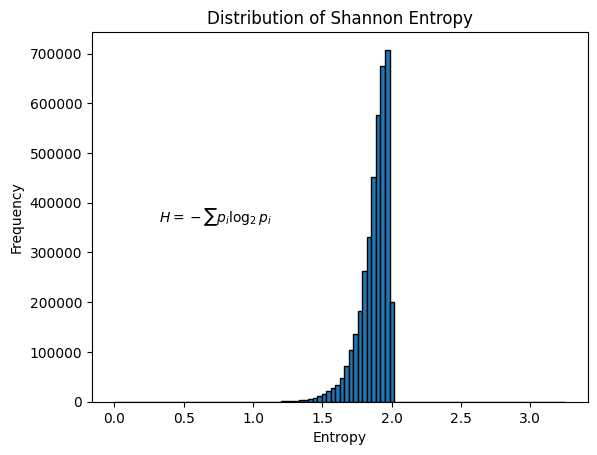

In [5]:
print(spacer_df["entropy"].describe())
# quick plot of the entropy distribution
import matplotlib.pyplot as plt
plt.hist(spacer_df["entropy"], bins=100, edgecolor='black')
plt.title('Distribution of Shannon Entropy')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.text(0.25, 0.5, '$H = -\sum p_{i}\log_{2} p_{i}$', ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

Adding a column for the number of masked bases in a spacer when using pydustmasker with a window size of 5 and a score threshold of 6.

In [6]:
spacer_df = spacer_df.with_columns(
    pl.col("seq").map_elements(lambda x: pdm.DustMasker(x, window_size=20, score_threshold=16).n_masked_bases, return_dtype=pl.Int64).alias("low_compx_n_masked")
    )
spacer_df["low_compx_n_masked"].value_counts().sort(by="low_compx_n_masked", descending=True)

low_compx_n_masked,count
i64,u32
40,3
39,3
38,6
37,6
36,10
…,…
9,1847
8,8713
7,35546


In [7]:
low_compx_spacers = spacer_df.filter(pl.col("low_compx_n_masked") > 0)
low_compx_spacers


seqid,seq,length,n_frac,a_frac,t_frac,c_frac,g_frac,entropy,low_compx_n_masked
str,str,u32,f64,f64,f64,f64,f64,f64,i64
"""MGYG000215836:MGYG000215836_17…","""TTGTTATTTTTTTTTTTTTTTTTTTTTTTT""",30,0.0,0.033333,0.933333,0.0,0.033333,0.420026,24
"""MGYG000284124:MGYG000284124_95…","""TTTTCTTTCGTTTTTTATTTTTTTTTTTTT""",30,0.0,0.033333,0.866667,0.066667,0.033333,0.76651,20
"""MGYG000084070:MGYG000084070_1:…","""TGTTTTTTTTTTTGTTTTTACTTTTTTTTT""",30,0.0,0.033333,0.866667,0.033333,0.066667,0.76651,28
"""MGYG000293011:MGYG000293011_47…","""TTATTTTTTATTTATTTTTTTATTTTTTT""",29,0.0,0.137931,0.862069,0.0,0.0,0.578795,29
"""3300017688_7:Ga0180017_100481:…","""TTTTTTTTTCCTCTTTTTTTTTTTTTTCTT…",33,0.0,0.0,0.848485,0.151515,0.0,0.613619,27
…,…,…,…,…,…,…,…,…,…
"""GCF_924101635.2:NZ_CAKMAA02000…","""AGGAAAAAAGCGCCAAGCGCGAGACCAGCA…",34,0.0,0.411765,0.0,0.264706,0.323529,1.561403,6
"""3300008130_20:Ga0114850_100045…","""AACACCGACAGCGACAAAAAAACGACAACG…",35,0.0,0.542857,0.0,0.285714,0.171429,1.431006,7
"""GCF_963666145.1:NZ_OY762614.1:…","""CCCCGGAAGAGAGAGAGAGAGAGCGCGAGA…",34,0.0,0.382353,0.0,0.176471,0.441176,1.492791,27


In [10]:
high_compx_spacers = spacer_df.filter(pl.col("low_compx_n_masked") == 0)
high_compx_spacers

seqid,seq,length,n_frac,a_frac,t_frac,c_frac,g_frac,entropy,low_compx_n_masked
str,str,u32,f64,f64,f64,f64,f64,f64,i64
"""MGYG000124313:MGYG000124313_31…","""TCTTTCTTTTTCTTTGTTTCTTTCTTTTTC""",30,0.0,0.0,0.766667,0.2,0.033333,0.921834,0
"""MGYG000222119:MGYG000222119_2:…","""TTTCTTCTTTTTCTTCTGATTTTTCTATTG…",35,0.0,0.057143,0.742857,0.142857,0.057143,1.191538,0
"""MGYG000205949:MGYG000205949_50…","""TTATATTTGTTATTTTTATTCTTTTAATTT…",31,0.0,0.193548,0.741935,0.032258,0.032258,1.09769,0
"""GCA_028719245.1:JAQUKG01000007…","""TTTTTCTTATTTCATTTTCTTTGATTT""",27,0.0,0.111111,0.740741,0.111111,0.037037,1.201245,0
"""3300029595_16:Ga0245140_101222…","""TTTTCATTTTTAATTTCTTTCATTTCTTTT""",30,0.0,0.133333,0.733333,0.133333,0.0,1.103307,0
…,…,…,…,…,…,…,…,…,…
"""GCF_964211445.1:NZ_CAXOQT01000…","""CCAACCCGCAGCCCACGCACCGGCAGCAGA…",32,0.0,0.25,0.0,0.5,0.25,1.5,0
"""GCF_964211445.1:NZ_CAXOQT01000…","""GCCAACCCGCAGCCCACGCACCGGCAGCAG…",33,0.0,0.242424,0.0,0.484848,0.272727,1.513202,0
"""MGYG000058057:MGYG000058057_89…","""AAAGAACCCAAAGAACCGAAGGAGGAGCCA…",33,0.0,0.515152,0.0,0.212121,0.272727,1.478707,0


In [41]:
low_entropy_spacers = spacer_df.filter(pl.col("entropy") <= 1.4)
low_entropy_spacers

seqid,seq,length,n_frac,a_frac,t_frac,c_frac,g_frac,entropy,low_compx_n_masked
str,str,u32,f64,f64,f64,f64,f64,f64,i64
"""MGYG000215836:MGYG000215836_17…","""TTGTTATTTTTTTTTTTTTTTTTTTTTTTT""",30,0.0,0.033333,0.933333,0.0,0.033333,0.420026,24
"""MGYG000284124:MGYG000284124_95…","""TTTTCTTTCGTTTTTTATTTTTTTTTTTTT""",30,0.0,0.033333,0.866667,0.066667,0.033333,0.76651,20
"""MGYG000084070:MGYG000084070_1:…","""TGTTTTTTTTTTTGTTTTTACTTTTTTTTT""",30,0.0,0.033333,0.866667,0.033333,0.066667,0.76651,28
"""MGYG000293011:MGYG000293011_47…","""TTATTTTTTATTTATTTTTTTATTTTTTT""",29,0.0,0.137931,0.862069,0.0,0.0,0.578795,29
"""3300017688_7:Ga0180017_100481:…","""TTTTTTTTTCCTCTTTTTTTTTTTTTTCTT…",33,0.0,0.0,0.848485,0.151515,0.0,0.613619,27
…,…,…,…,…,…,…,…,…,…
"""GCF_934476685.1:NZ_CAKSNX01000…","""GAGCGGAGCGCAGGGGCGAGGGGGAGCAGA…",34,0.0,0.235294,0.0,0.176471,0.588235,1.3831,0
"""MGYG000304187:MGYG000304187_9:…","""AGAAGAAAAAGAGACACCAGAAGAGCAGGA…",34,0.0,0.558824,0.0,0.147059,0.294118,1.395123,0
"""GCF_964023245.1:NZ_OZ026884.1:…","""CGCCCCAGCCGCCGCCCCCGGAGCCCGGCC…",35,0.0,0.114286,0.0,0.6,0.285714,1.316199,0


In [13]:
low_entropy_spacers = high_compx_spacers.filter(pl.col("entropy") <= 1.4)
low_entropy_spacers

seqid,seq,length,n_frac,a_frac,t_frac,c_frac,g_frac,entropy,low_compx_n_masked
str,str,u32,f64,f64,f64,f64,f64,f64,i64
"""MGYG000124313:MGYG000124313_31…","""TCTTTCTTTTTCTTTGTTTCTTTCTTTTTC""",30,0.0,0.0,0.766667,0.2,0.033333,0.921834,0
"""MGYG000222119:MGYG000222119_2:…","""TTTCTTCTTTTTCTTCTGATTTTTCTATTG…",35,0.0,0.057143,0.742857,0.142857,0.057143,1.191538,0
"""MGYG000205949:MGYG000205949_50…","""TTATATTTGTTATTTTTATTCTTTTAATTT…",31,0.0,0.193548,0.741935,0.032258,0.032258,1.09769,0
"""GCA_028719245.1:JAQUKG01000007…","""TTTTTCTTATTTCATTTTCTTTGATTT""",27,0.0,0.111111,0.740741,0.111111,0.037037,1.201245,0
"""3300029595_16:Ga0245140_101222…","""TTTTCATTTTTAATTTCTTTCATTTCTTTT""",30,0.0,0.133333,0.733333,0.133333,0.0,1.103307,0
…,…,…,…,…,…,…,…,…,…
"""MGYG000334016:MGYG000334016_12…","""NNNNNNNNNNNNNNNNNNNNNNNNNNNNNN…",37,1.0,0.0,0.0,0.0,0.0,0.0,0
"""GCF_934476685.1:NZ_CAKSNX01000…","""GAGCGGAGCGCAGGGGCGAGGGGGAGCAGA…",34,0.0,0.235294,0.0,0.176471,0.588235,1.3831,0
"""MGYG000304187:MGYG000304187_9:…","""AGAAGAAAAAGAGACACCAGAAGAGCAGGA…",34,0.0,0.558824,0.0,0.147059,0.294118,1.395123,0


In [14]:
fourmer_spacers = high_compx_spacers.filter(
    pl.all_horizontal(pl.selectors.starts_with("a_", "c_", "g_", "t_") > 0) &
    ~pl.any_horizontal(pl.selectors.starts_with("n_") > 0) 
)
fourmer_spacers

seqid,seq,length,n_frac,a_frac,t_frac,c_frac,g_frac,entropy,low_compx_n_masked
str,str,u32,f64,f64,f64,f64,f64,f64,i64
"""MGYG000222119:MGYG000222119_2:…","""TTTCTTCTTTTTCTTCTGATTTTTCTATTG…",35,0.0,0.057143,0.742857,0.142857,0.057143,1.191538,0
"""MGYG000205949:MGYG000205949_50…","""TTATATTTGTTATTTTTATTCTTTTAATTT…",31,0.0,0.193548,0.741935,0.032258,0.032258,1.09769,0
"""GCA_028719245.1:JAQUKG01000007…","""TTTTTCTTATTTCATTTTCTTTGATTT""",27,0.0,0.111111,0.740741,0.111111,0.037037,1.201245,0
"""GCA_028693085.1:JAQUWC01000006…","""TTAATTTTTATTTATTGTTTTATTTTACTT""",30,0.0,0.2,0.733333,0.033333,0.033333,1.119648,0
"""MGYG000038823:MGYG000038823_19…","""TTTTTCTTTCGTTTTGATTTTGTATTTTTA""",30,0.0,0.1,0.733333,0.066667,0.1,1.252982,0
…,…,…,…,…,…,…,…,…,…
"""GCF_900605005.1:NZ_LR027558.1:…","""GTGAGCCCAACACCAGCAGCGCCGCCACCA…",40,0.0,0.3,0.025,0.45,0.225,1.65674,0
"""GCF_902143375.2:NZ_CABFVA02000…","""AAGCGGGCGAGAGGGGAGACCACAAAGAGG…",40,0.0,0.325,0.025,0.2,0.45,1.642819,0
"""GCF_963529995.1:NZ_CAUSCY01000…","""TCGACCGCAGCGAAGAAGACCACCGCGACC…",40,0.0,0.3,0.025,0.4,0.275,1.695096,0


In [ ]:
N_spacers = spacer_df.filter(pl.col("n_frac") > 0)
N_spacers

seqid,seq,length,n_frac,a_frac,t_frac,c_frac,g_frac,low_compx_n_masked
str,str,u32,f64,f64,f64,f64,f64,i64
"""GCA_019561555.1:JAHEQB01000003…","""TTTTTTTATCACCTTTTAAAGATTTTTAAG…",38,0.026316,0.236842,0.605263,0.078947,0.052632,18
"""GCA_019561555.1:JAHEQB01000003…","""TTTTTTATCACCTTTTAAAGATTTTTAAGN…",37,0.027027,0.243243,0.594595,0.081081,0.054054,17
"""GCA_003483675.1:DMYK01000440.1…","""TGCTTCTTCTATTTGTTGTTTACGTTGTGN…",31,0.064516,0.064516,0.548387,0.129032,0.193548,0
"""GCA_020692945.1:JAIMJY01000008…","""TATATTTTATATTTTATTTTTATNNNNNNN…",34,0.323529,0.176471,0.5,0.0,0.0,5
"""GCA_016841625.1:JAENYU01000001…","""TTACTTTTTTNNNNNNNNNNTTTCCTTTAC…",31,0.322581,0.064516,0.483871,0.129032,0.0,6
…,…,…,…,…,…,…,…,…
"""MGYG000051310:MGYG000051310_92…","""NNNNNNNNNNNNNNNNNNNNNNNNNNNNNN…",36,1.0,0.0,0.0,0.0,0.0,0
"""GCF_900129055.1:NZ_FQUZ0100002…","""GAGGAANNNNNNNNNNNNNNNNNNNNNNNN…",32,0.78125,0.09375,0.0,0.0,0.125,0
"""GCF_900230225.1:NZ_OCNH0100000…","""CNNNNNNNNNNNNNNNNNNNNNNNNNNNNN…",36,0.944444,0.0,0.0,0.055556,0.0,0


Will use LCC from biopython (https://github.com/biopython/biopython/blob/e451db211bdd855a5d0f1f6bba18985ffee12696/Bio/SeqUtils/lcc.py)

In [15]:
def lcc_mult(seq, wsize):
    """Calculate Local Composition Complexity (LCC) values over sliding window.

    Returns a list of floats, the LCC values for a sliding window over
    the sequence.

    seq - an unambiguous DNA sequence (a string or Seq object)
    wsize - window size, integer

    The result is the same as applying lcc_simp multiple times, but this
    version is optimized for speed. The optimization works by using the
    value of previous window as a base to compute the next one.
    """
    l4 = math.log(4)
    seq = seq.upper()
    tamseq = len(seq)
    compone = [0]
    lccsal = []
    for i in range(wsize):
        compone.append(((i + 1) / wsize) * math.log((i + 1) / wsize) / l4)
    window = seq[0:wsize]
    cant_a = window.count("A")
    cant_c = window.count("C")
    cant_t = window.count("T")
    cant_g = window.count("G")
    term_a = compone[cant_a]
    term_c = compone[cant_c]
    term_t = compone[cant_t]
    term_g = compone[cant_g]
    lccsal.append(-(term_a + term_c + term_t + term_g))
    tail = seq[0]
    for x in range(tamseq - wsize):
        window = seq[x + 1 : wsize + x + 1]
        if tail == window[-1]:
            lccsal.append(lccsal[-1])
        elif tail == "A":
            cant_a -= 1
            if window.endswith("C"):
                cant_c += 1
                term_a = compone[cant_a]
                term_c = compone[cant_c]
                lccsal.append(-(term_a + term_c + term_t + term_g))
            elif window.endswith("T"):
                cant_t += 1
                term_a = compone[cant_a]
                term_t = compone[cant_t]
                lccsal.append(-(term_a + term_c + term_t + term_g))
            elif window.endswith("G"):
                cant_g += 1
                term_a = compone[cant_a]
                term_g = compone[cant_g]
                lccsal.append(-(term_a + term_c + term_t + term_g))
        elif tail == "C":
            cant_c -= 1
            if window.endswith("A"):
                cant_a += 1
                term_a = compone[cant_a]
                term_c = compone[cant_c]
                lccsal.append(-(term_a + term_c + term_t + term_g))
            elif window.endswith("T"):
                cant_t += 1
                term_c = compone[cant_c]
                term_t = compone[cant_t]
                lccsal.append(-(term_a + term_c + term_t + term_g))
            elif window.endswith("G"):
                cant_g += 1
                term_c = compone[cant_c]
                term_g = compone[cant_g]
                lccsal.append(-(term_a + term_c + term_t + term_g))
        elif tail == "T":
            cant_t -= 1
            if window.endswith("A"):
                cant_a += 1
                term_a = compone[cant_a]
                term_t = compone[cant_t]
                lccsal.append(-(term_a + term_c + term_t + term_g))
            elif window.endswith("C"):
                cant_c += 1
                term_c = compone[cant_c]
                term_t = compone[cant_t]
                lccsal.append(-(term_a + term_c + term_t + term_g))
            elif window.endswith("G"):
                cant_g += 1
                term_t = compone[cant_t]
                term_g = compone[cant_g]
                lccsal.append(-(term_a + term_c + term_t + term_g))
        elif tail == "G":
            cant_g -= 1
            if window.endswith("A"):
                cant_a += 1
                term_a = compone[cant_a]
                term_g = compone[cant_g]
                lccsal.append(-(term_a + term_c + term_t + term_g))
            elif window.endswith("C"):
                cant_c += 1
                term_c = compone[cant_c]
                term_g = compone[cant_g]
                lccsal.append(-(term_a + term_c + term_t + term_g))
            elif window.endswith("T"):
                cant_t += 1
                term_t = compone[cant_t]
                term_g = compone[cant_g]
                lccsal.append(-(term_a + term_c + term_t + term_g))
        tail = window[0]
    return lccsal


def lcc_simp(seq):
    """Calculate Local Composition Complexity (LCC) for a sequence.

    seq - an unambiguous DNA sequence (a string or Seq object)

    Returns the Local Composition Complexity (LCC) value for the entire
    sequence (as a float).

    Reference:
    Andrzej K Konopka (2005) Sequence Complexity and Composition
    https://doi.org/10.1038/npg.els.0005260
    """
    wsize = len(seq)
    seq = seq.upper()
    l4 = math.log(4)
    # Check to avoid calculating the log of 0.
    if "A" not in seq:
        term_a = 0
    else:
        term_a = (seq.count("A") / wsize) * math.log(seq.count("A") / wsize) / l4
    if "C" not in seq:
        term_c = 0
    else:
        term_c = (seq.count("C") / wsize) * math.log(seq.count("C") / wsize) / l4
    if "T" not in seq:
        term_t = 0
    else:
        term_t = (seq.count("T") / wsize) * math.log(seq.count("T") / wsize) / l4
    if "G" not in seq:
        term_g = 0
    else:
        term_g = (seq.count("G") / wsize) * math.log(seq.count("G") / wsize) / l4
    return -(term_a + term_c + term_t + term_g)

In [35]:
testdf = spacer_df.head(12116)
testdf = testdf.with_columns(
    pl.col("seq").map_elements(lambda x: lcc_simp(x), return_dtype=pl.Float64).alias("lcc")
)
testdf["lcc"].describe()
# testdf.filter(pl.col("lcc") < 0)
# testdf.filter(pl.col("lcc") < 0).head(3)


statistic,value
str,f64
"""count""",12116.0
"""null_count""",0.0
"""mean""",0.727165
"""std""",0.063331
"""min""",0.210013
"""25%""",0.695491
"""50%""",0.741916
"""75%""",0.772576
"""max""",0.813469


In [ ]:
import kcounter
def test_kmer(seq):
	flag = ""
	# print(f"SEQ ==> {seq}")
	if "N" in seq or "n" in seq:
		flag = "low_complexity_N"
	else:
		for i in range(8,1,-1):
			counts = list(kcounter.count_kmers(seq, i, canonical_kmers=False).values())
			# print(f"\t{counts}")
			max_c = max(counts)
			ratio = max_c / sum(counts)
			# print(f"{seq} // {i} // {max(counts)} // {sum(counts)} // {ratio} // {counts}")
			# if ratio > 0.3: ## Most frequent k-mer above 30%, we flag
			### Empirical thresholds for now
			if i>=6 and max_c>=2: ## most frequent kmer is found twice or more for k=6, 7, or 8 -> we flag
				flag = "low_complexity_kmer" + str(i)
				break
			elif i==5 and max_c>=3: ## most frequent kmer is found three times or more for k=5 -> we flag
				flag = "low_complexity_kmer" + str(i)
				break
			elif i==4 and ratio>=0.15: ## most frequent kmer is found at a frequency above 15% for k=4 -> we flag
				flag = "low_complexity_kmer" + str(i)
				break
			elif i==3 and ratio>=0.2: ## most frequent kmer is found at a frequency above 20% for k=3 -> we flag
				flag = "low_complexity_kmer" + str(i)
				break
			elif i==2 and ratio>=0.3: ## most frequent kmer is found at a frequency above 30% for k=2 -> we flag
				flag = "low_complexity_kmer" + str(i)
				break
	return flag
kcounter.count_kmers("ATGCTGG",5)

{'TGCTG': 1.0, 'GCTGG': 1.0, 'ATGCT': 1.0}

In [233]:
test_df = spacer_df.head(100000)
test_df = test_df.with_columns(
    (pl.col("seq").map_elements(lambda x: kcounter.count_kmers(x, 6, canonical_kmers=False).values(),return_dtype=pl.List(pl.Float32)).alias("6mer_counts"))
)
type((test_df["6mer_counts"].item(1)))
(test_df["6mer_counts"].item(1))
test_df

seqid,seq,length,n_frac,a_frac,t_frac,c_frac,g_frac,entropy,low_compx_n_masked,6mer_counts
str,str,u32,f64,f64,f64,f64,f64,f64,i64,list[f32]
"""MGYG000215836:MGYG000215836_17…","""TTGTTATTTTTTTTTTTTTTTTTTTTTTTT""",30,0.0,0.033333,0.933333,0.0,0.033333,0.420026,24,"[1.0, 1.0, … 1.0]"
"""MGYG000284124:MGYG000284124_95…","""TTTTCTTTCGTTTTTTATTTTTTTTTTTTT""",30,0.0,0.033333,0.866667,0.066667,0.033333,0.76651,20,"[1.0, 1.0, … 1.0]"
"""MGYG000084070:MGYG000084070_1:…","""TGTTTTTTTTTTTGTTTTTACTTTTTTTTT""",30,0.0,0.033333,0.866667,0.033333,0.066667,0.76651,28,"[10.0, 1.0, … 1.0]"
"""MGYG000293011:MGYG000293011_47…","""TTATTTTTTATTTATTTTTTTATTTTTTT""",29,0.0,0.137931,0.862069,0.0,0.0,0.578795,29,"[1.0, 3.0, … 3.0]"
"""3300017688_7:Ga0180017_100481:…","""TTTTTTTTTCCTCTTTTTTTTTTTTTTCTT…",33,0.0,0.0,0.848485,0.151515,0.0,0.613619,27,"[1.0, 1.0, … 2.0]"
…,…,…,…,…,…,…,…,…,…,…
"""GCF_001601575.1:NZ_LOHZ0100002…","""GTTACTTCTTTTATTTTGAACGATGCCGCC…",37,0.0,0.135135,0.486486,0.243243,0.135135,1.78223,0,"[1.0, 1.0, … 1.0]"
"""GCF_001601575.1:NZ_LOHZ0100002…","""TCAAGTAAATTCTTTGGTTTTGATATTATC…",37,0.0,0.297297,0.486486,0.108108,0.108108,1.719929,0,"[1.0, 1.0, … 1.0]"
"""GCF_001601575.1:NZ_LOHZ0100002…","""GATGAAAAAATTGTTTTTACTATCGTTGGT…",37,0.0,0.297297,0.486486,0.054054,0.162162,1.679124,6,"[1.0, 1.0, … 1.0]"


In [252]:
i

NameError: name 'i' is not defined

In [253]:
def count_kmers_df(df: pl.DataFrame, seq_col: str = "seq", k: int = 3, relative: bool = False) -> pl.DataFrame:
    """Calculate k-mer counts for all sequences in a DataFrame"""
    # Split sequences into characters
    split_chars_expr = pl.col(seq_col).str.split('').alias('chars')
    
    # Create k-mers by shifting and concatenating
    create_kmers_expr = pl.concat_str(
        [pl.col('chars').shift(-i).over('seqid') for i in range(k)]
    ).alias('substrings')
    
    # Filter for complete k-mers only
    filter_complete_kmers_expr = pl.col('substrings').str.len_chars() == k
    
    # Aggregate expressions
    agg_exprs = [
        pl.first(seq_col),  # Keep the original sequence
        pl.col('substrings').value_counts(normalize=relative).alias('kmer_counts'),
        pl.exclude(seq_col, 'chars', 'substrings').first()  # Keep all other original columns
    ]
    
    return (
        df
        .with_columns(split_chars_expr)
        .explode('chars')
        .with_columns(create_kmers_expr)
        .filter(filter_complete_kmers_expr)
        .group_by('seqid', maintain_order=True)
        .agg(*agg_exprs)
    )

def filter_repetitive_kmers(df: pl.DataFrame, seq_col: str = "seq", k: int = 5, max_count: int = 10) -> pl.DataFrame:
    """Filter sequences that have any k-mer appearing more than max_count times"""
    # First get k-mer counts
    df_with_kmers = count_kmers_df(df, seq_col, k, relative=False)
    
    # Filter for sequences without highly repetitive k-mers
    filter_repetitive_expr = ~pl.col('kmer_counts').list.eval(
        pl.element().struct.field('count') > max_count
    ).list.any()
    
    return df_with_kmers.filter(filter_repetitive_expr)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   1.,
          1.,   0.,   3.,   2.,   1.,   2.,   4.,   2.,   1.,   1.,   2.,
          4.,   2.,   3.,  13.,   9.,   4.,   7.,  12.,  33.,  13.,   5.,
          8.,  16.,  13.,  16.,  21.,  37.,  14.,  15.,  35.,  24.,  40.,
         21.,  25.,  26.,  43.,  57.,  64.,  52.,  76.,  78.,  72.,  85.,
         94.,  82., 106.,  88., 103., 138., 124., 140., 150., 187., 141.,
        170., 157., 158., 171., 150., 209., 150., 214., 191., 227., 215.,
        223., 206., 204., 202., 206., 179., 187., 153.,  95.,  92.,  50.,
         19.]),
 array([0.420026  , 0.43393928, 0.44785256, 0.46176584, 0.47567911,
        0.48959239, 0.50350567, 0.51741895, 0.53133222, 0.5452455 ,
        0.55915878, 0.57307206, 0.58698534, 0.60089861, 0.61481189,
        0.62872517, 0.64263845, 0.65655172, 0.670465  , 0.68437828,
        0.69829156, 0.71220484, 0.72611811, 0.

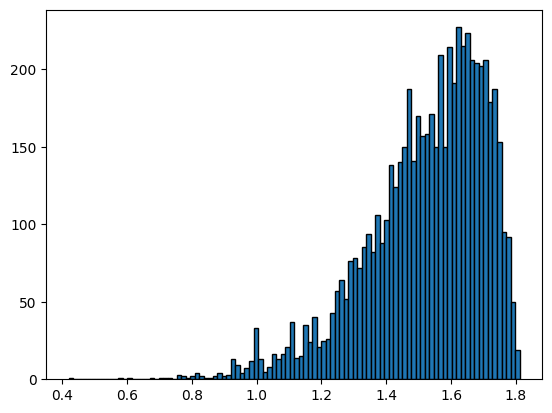

In [249]:
plt.hist(test_df2['entropy'], bins=100, edgecolor='black')

In [204]:
test_df = spacer_df.head(100000)
test_df = test_df.with_columns(
    pl.col("seq")
    .str.count_matches("A|C|G|T|N")
    .list.eval(pl.element().value_counts()) # The new way
    .alias("char_counts")
)

test_df
# test_df.unnest("char_counts")

InvalidOperationError: list.eval operation not supported for dtype `u32`

In [115]:
# TODO: compare or test using this from bbtools:
# # kmercountshort.sh in=file.fa out=kcount.tsv k=5 skip=5 

In [ ]:
test_df = spacer_df.head(100000)
test_df = test_df.with_columns(
    pl.col("seq").str.split("").alias("character")
).group_by("character").len()
test_df

AttributeError: 'Expr' object has no attribute 'count_by'

In [ ]:
from collections import defaultdict
def count_kmers_defdict_python(seq: str, k: int, relative: bool = False) -> dict:
    if not seq or len(seq) < k:
        return {}
    kmers = defaultdict(int)
    for i in range(len(seq) - k + 1):
        kmer = seq[i : i + k].upper()
        if "N" not in kmer:
            kmers[kmer] += 1
    total = sum(kmers.values())
    return {k: v / total if relative else v for k, v in kmers.items()} if total > 0 else {}



In [167]:
test_df = spacer_df.head(100000)
test_df = test_df.with_columns(
    (pl.col("seq").map_elements(lambda x: count_kmers(x, 1),return_dtype=pl.Struct).alias("kmer_counts_6"))
)
type((test_df["kmer_counts_6"].item(1)))
(test_df["kmer_counts_6"].item(1))
test_df

SchemaError: expected output type 'Struct({})', got 'Struct({'T': Int64, 'G': Int64, 'A': Int64, 'C': Int64})'; set `return_dtype` to the proper datatype

(Next steps are in the subsampling notebook)